In [ ]:
import pandas as pd

# Load your DataFrame
df = pd.read_csv('/content/drive/MyDrive/subset result.csv') # Example if your dataset is in a CSV file
df['item_1A'] = df['item_1A'].astype(str)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

train_df, val_df = train_test_split(df, test_size=0.2, random_state=29)

df_majority = train_df[train_df.high_30 == 1]
df_minority = train_df[train_df.high_30 == 0]

# Downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=29) # reproducible results

# Combine minority class with downsampled majority class
train_df = pd.concat([df_majority_downsampled, df_minority])

train_df = resample(train_df,
                                   replace=False,    # sample without replacement
                                   n_samples=len(train_df),     # to match minority class
                                   random_state=29) # reproducible results

# Display new class counts
print(train_df.high_30.value_counts())

0    323
1    323
Name: high_30, dtype: int64


In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

def tokenize_function(examples):
    return tokenizer(examples['item_1A'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_df.apply(tokenize_function, axis=1)
val_dataset = val_df.apply(tokenize_function, axis=1)


In [ ]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['high_30'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train = TextDataset(train_dataset, train_df['high_30'].tolist())
val = TextDataset(val_dataset, val_df['high_30'].tolist())

In [ ]:
train_attention_mask = []
train_input_ids = []
for element in train_dataset:
  train_attention_mask.append(element['attention_mask'])
  train_input_ids.append(element['input_ids'])

test_attention_mask = []
test_input_ids = []
for element in val_dataset:
  test_attention_mask.append(element['attention_mask'])
  test_input_ids.append(element['input_ids'])

In [ ]:
df_train = pd.DataFrame({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask,
    'labels': train.labels
})

df_test = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_mask,
    'labels': val.labels
})

In [ ]:
dataset = []
for _, row in df_train.iterrows():
    # Creating a dictionary for each row
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),  # Convert to tensor
        'attention_mask': torch.tensor(row['attention_mask']),  # Convert to tensor
        'labels': row['labels']  # Assuming labels are already in the correct format
    }
    dataset.append(data_point)

test_dataset = []
for _, row in df_test.iterrows():
    # Creating a dictionary for each row
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),  # Convert to tensor
        'attention_mask': torch.tensor(row['attention_mask']),  # Convert to tensor
        'labels': row['labels']  # Assuming labels are already in the correct format
    }
    test_dataset.append(data_point)

In [ ]:
def create_batches(dataset, batch_size):
    batches = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]
        batch_input_ids = torch.stack([item['input_ids'] for item in batch])
        batch_attention_mask = torch.stack([item['attention_mask'] for item in batch])
        batch_labels = torch.tensor([item['labels'] for item in batch])

        batches.append({
            'input_ids': batch_input_ids,
            'attention_mask': batch_attention_mask,
            'labels': batch_labels
        })
    return batches

# Example usage
batch_size = 4
batches = create_batches(dataset, batch_size)
test_batches = create_batches(test_dataset, batch_size)

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for lr in [1e-3, 1e-5, 1e-7, 1e-9]:
    print(lr)
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

0.001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 1.9163541243566822
Epoch 0: Average Validation Loss: 1.5415996511777241
Epoch 1: Average Training Loss: 1.6407261087248723
Epoch 1: Average Validation Loss: 2.8439869483311973
Epoch 2: Average Training Loss: 2.6366522212823233
Epoch 2: Average Validation Loss: 0.7046774427096049
Epoch 3: Average Training Loss: 0.8347844084103903
Epoch 3: Average Validation Loss: 0.6932751735051473
Epoch 4: Average Training Loss: 0.7275562087694804
Epoch 4: Average Validation Loss: 0.7077712615331014
Epoch 5: Average Training Loss: 0.763711154460907
Epoch 5: Average Validation Loss: 0.7254773577054342
Epoch 6: Average Training Loss: 0.8352446953455607
Epoch 6: Average Validation Loss: 0.6979722778002421
Epoch 7: Average Training Loss: 0.7449983755747477
Epoch 7: Average Validation Loss: 0.6955320636431376
Epoch 8: Average Training Loss: 0.7426822781562805
Epoch 8: Average Validation Loss: 0.6940363844235738
Epoch 9: Average Training Loss: 0.7179312805334727
Epoch 9: Avera

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7473663985729218
Epoch 0: Average Validation Loss: 0.7020556728045145
Epoch 1: Average Training Loss: 0.6998404562473297
Epoch 1: Average Validation Loss: 0.6997839212417603
Epoch 2: Average Training Loss: 0.6962294181187948
Epoch 2: Average Validation Loss: 0.6961513559023539
Epoch 3: Average Training Loss: 0.6795992056528727
Epoch 3: Average Validation Loss: 0.6932157278060913
Epoch 4: Average Training Loss: 0.667161206404368
Epoch 4: Average Validation Loss: 0.6908549865086874
Epoch 5: Average Training Loss: 0.6694405774275461
Epoch 5: Average Validation Loss: 0.6881058812141418
Epoch 6: Average Training Loss: 0.6608181595802307
Epoch 6: Average Validation Loss: 0.6839855710665385
Epoch 7: Average Training Loss: 0.6484374105930328
Epoch 7: Average Validation Loss: 0.6773912111918131
Epoch 8: Average Training Loss: 0.6144524017969767
Epoch 8: Average Validation Loss: 0.6663873394330343
Epoch 9: Average Training Loss: 0.5814040899276733
Epoch 9: Avera

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7074526250362396
Epoch 0: Average Validation Loss: 0.6893559098243713
Epoch 1: Average Training Loss: 0.6979543069998423
Epoch 1: Average Validation Loss: 0.689349095026652
Epoch 2: Average Training Loss: 0.690648357073466
Epoch 2: Average Validation Loss: 0.6893332997957865
Epoch 3: Average Training Loss: 0.6929985483487447
Epoch 3: Average Validation Loss: 0.6893147826194763
Epoch 4: Average Training Loss: 0.7063116729259491
Epoch 4: Average Validation Loss: 0.689299484093984
Epoch 5: Average Training Loss: 0.7052874167760214
Epoch 5: Average Validation Loss: 0.6892802913983663
Epoch 6: Average Training Loss: 0.7105837563673655
Epoch 6: Average Validation Loss: 0.6892604827880859
Epoch 7: Average Training Loss: 0.6915076275666555
Epoch 7: Average Validation Loss: 0.6892420053482056
Epoch 8: Average Training Loss: 0.6912743151187897
Epoch 8: Average Validation Loss: 0.689224640528361
Epoch 9: Average Training Loss: 0.7140164077281952
Epoch 9: Average 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.702162524064382
Epoch 0: Average Validation Loss: 0.6949081818262736
Epoch 1: Average Training Loss: 0.710683008035024
Epoch 1: Average Validation Loss: 0.694908062616984
Epoch 2: Average Training Loss: 0.7012970447540283
Epoch 2: Average Validation Loss: 0.6949079632759094
Epoch 3: Average Training Loss: 0.706020732720693
Epoch 3: Average Validation Loss: 0.6949079235394796
Epoch 4: Average Training Loss: 0.702946941057841
Epoch 4: Average Validation Loss: 0.6949078838030497
Epoch 5: Average Training Loss: 0.6907159785429636
Epoch 5: Average Validation Loss: 0.6949078440666199
Epoch 6: Average Training Loss: 0.6920614143212637
Epoch 6: Average Validation Loss: 0.6949077447255453
Epoch 7: Average Training Loss: 0.6986486713091532
Epoch 7: Average Validation Loss: 0.6949077248573303
Epoch 8: Average Training Loss: 0.6999455293019613
Epoch 8: Average Validation Loss: 0.6949076652526855
Epoch 9: Average Training Loss: 0.7085342804590861
Epoch 9: Average V

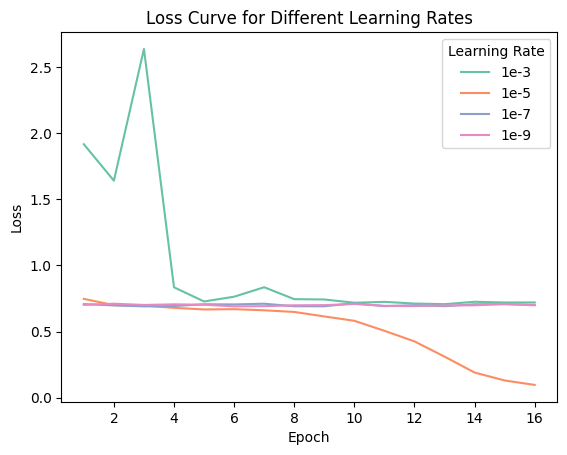

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updating the DataFrame without "Loss Series" in the series labels
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["1e-3", "1e-5", "1e-7", "1e-9"][i]] = loss_list  # Using just the series label like '1e-3'

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='Learning Rate', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='Learning Rate', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Learning Rate')
plt.show()

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for batch in [2, 4, 8, 16]:
    print(batch)

    batch_size = batch
    batches = create_batches(dataset, batch_size)
    test_batches = create_batches(test_dataset, batch_size)
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.8620802288254102
Epoch 0: Average Validation Loss: 0.6877789258956909
Epoch 1: Average Training Loss: 0.7098615368207296
Epoch 1: Average Validation Loss: 0.6841280043125153
Epoch 2: Average Training Loss: 0.7019731029868126
Epoch 2: Average Validation Loss: 0.6862835645675659
Epoch 3: Average Training Loss: 0.6969380875428518
Epoch 3: Average Validation Loss: 0.6885193943977356
Epoch 4: Average Training Loss: 0.6906897773345312
Epoch 4: Average Validation Loss: 0.6864031672477722
Epoch 5: Average Training Loss: 0.6698289041717848
Epoch 5: Average Validation Loss: 0.6880936741828918
Epoch 6: Average Training Loss: 0.6456168914834658
Epoch 6: Average Validation Loss: 0.7023328244686127
Epoch 7: Average Training Loss: 0.5300199712316195
Epoch 7: Average Validation Loss: 0.6692871183156968
Epoch 8: Average Training Loss: 0.4457877591873209
Epoch 8: Average Validation Loss: 0.7760766804218292
Epoch 9: Average Training Loss: 0.45907092466950417
Epoch 9: Ave

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7952922582626343
Epoch 0: Average Validation Loss: 0.6908037304878235
Epoch 1: Average Training Loss: 0.6916182637214661
Epoch 1: Average Validation Loss: 0.6874661087989807
Epoch 2: Average Training Loss: 0.675245925784111
Epoch 2: Average Validation Loss: 0.6874942421913147
Epoch 3: Average Training Loss: 0.6858186771472295
Epoch 3: Average Validation Loss: 0.6898367762565613
Epoch 4: Average Training Loss: 0.6934428860743841
Epoch 4: Average Validation Loss: 0.6920517444610595
Epoch 5: Average Training Loss: 0.6692360391219457
Epoch 5: Average Validation Loss: 0.6935860633850097
Epoch 6: Average Training Loss: 0.6346417367458344
Epoch 6: Average Validation Loss: 0.6938069939613343
Epoch 7: Average Training Loss: 0.5865024427572886
Epoch 7: Average Validation Loss: 0.6946609377861023
Epoch 8: Average Training Loss: 0.48987958083550137
Epoch 8: Average Validation Loss: 0.6924855470657348
Epoch 9: Average Training Loss: 0.3304599126180013
Epoch 9: Aver

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7290184199810028
Epoch 0: Average Validation Loss: 0.7020413478215536
Epoch 1: Average Training Loss: 0.7081063588460287
Epoch 1: Average Validation Loss: 0.7004975279172262
Epoch 2: Average Training Loss: 0.6979406674702963
Epoch 2: Average Validation Loss: 0.6980191866556803
Epoch 3: Average Training Loss: 0.6877095202604929
Epoch 3: Average Validation Loss: 0.6957880854606628
Epoch 4: Average Training Loss: 0.681365450223287
Epoch 4: Average Validation Loss: 0.6940341393152872
Epoch 5: Average Training Loss: 0.6638182004292806
Epoch 5: Average Validation Loss: 0.6922413309415182
Epoch 6: Average Training Loss: 0.658752034107844
Epoch 6: Average Validation Loss: 0.6895516514778137
Epoch 7: Average Training Loss: 0.6614818076292673
Epoch 7: Average Validation Loss: 0.6853153705596924
Epoch 8: Average Training Loss: 0.6363283197085062
Epoch 8: Average Validation Loss: 0.6784934600194296
Epoch 9: Average Training Loss: 0.6260852416356405
Epoch 9: Averag

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7234050234158834
Epoch 0: Average Validation Loss: 0.7065849006175995
Epoch 1: Average Training Loss: 0.7014421621958414
Epoch 1: Average Validation Loss: 0.7055329382419586
Epoch 2: Average Training Loss: 0.6929170886675516
Epoch 2: Average Validation Loss: 0.7037525773048401
Epoch 3: Average Training Loss: 0.6987455685933431
Epoch 3: Average Validation Loss: 0.7017833292484283
Epoch 4: Average Training Loss: 0.6785311897595724
Epoch 4: Average Validation Loss: 0.699740082025528
Epoch 5: Average Training Loss: 0.6859985788663229
Epoch 5: Average Validation Loss: 0.6978676617145538
Epoch 6: Average Training Loss: 0.6777108510335287
Epoch 6: Average Validation Loss: 0.6961070597171783
Epoch 7: Average Training Loss: 0.6771470705668131
Epoch 7: Average Validation Loss: 0.6944294571876526
Epoch 8: Average Training Loss: 0.6751509110132853
Epoch 8: Average Validation Loss: 0.6925140619277954
Epoch 9: Average Training Loss: 0.6621261040369669
Epoch 9: Avera

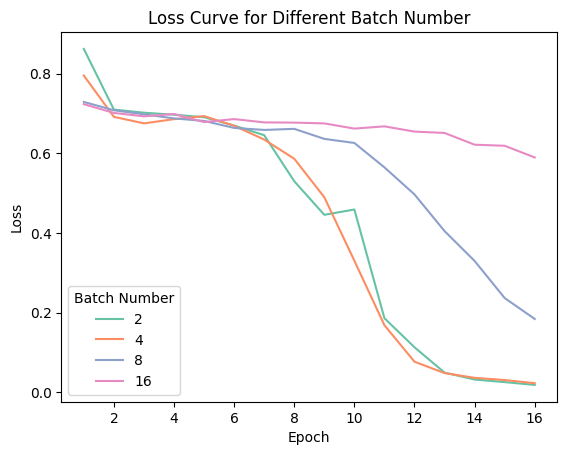

In [ ]:
# Updating the DataFrame without "Loss Series" in the series labels
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["2", "4", "8", "16"][i]] = loss_list  # Using just the series label like '1e-3'

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='Batch Number', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='Batch Number', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Batch Number')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Batch Number')
plt.show()

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for dropout in [0.2, 0.3, 0.4, 0.5]:
    print(lr)
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True, seq_classif_dropout=dropout)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    # Number of training epochs
    num_epochs = 16

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels)
        # print("Accuracy:", accuracy)
        # print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

1e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.7050702969233195
Epoch 0: Average Validation Loss: 0.6865716457366944
Epoch 1: Average Training Loss: 0.6908773531516393
Epoch 1: Average Validation Loss: 0.6878753423690795
Epoch 2: Average Training Loss: 0.6711007058620453
Epoch 2: Average Validation Loss: 0.6880569577217102
Epoch 3: Average Training Loss: 0.6365139385064443
Epoch 3: Average Validation Loss: 0.6803313732147217
Epoch 4: Average Training Loss: 0.5893890758355459
Epoch 4: Average Validation Loss: 0.6610684037208557
Epoch 5: Average Training Loss: 0.47483087579409283
Epoch 5: Average Validation Loss: 0.6584758162498474
Epoch 6: Average Training Loss: 0.3151585745314757
Epoch 6: Average Validation Loss: 0.7153826117515564
Epoch 7: Average Training Loss: 0.16205614494780698
Epoch 7: Average Validation Loss: 0.8387298047542572
Epoch 8: Average Training Loss: 0.09376340514669816
Epoch 8: Average Validation Loss: 1.001403307914734
Epoch 9: Average Training Loss: 0.06156964569042126
Epoch 9: A

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.7075518667697906
Epoch 0: Average Validation Loss: 0.6869673371315003
Epoch 1: Average Training Loss: 0.6768178393443426
Epoch 1: Average Validation Loss: 0.6777531743049622
Epoch 2: Average Training Loss: 0.6746823837359747
Epoch 2: Average Validation Loss: 0.6658308863639831
Epoch 3: Average Training Loss: 0.6343151132265726
Epoch 3: Average Validation Loss: 0.6491071939468384
Epoch 4: Average Training Loss: 0.5878818035125732
Epoch 4: Average Validation Loss: 0.6301629662513732
Epoch 5: Average Training Loss: 0.46687091886997223
Epoch 5: Average Validation Loss: 0.6441904664039612
Epoch 6: Average Training Loss: 0.29961298406124115
Epoch 6: Average Validation Loss: 0.6902412801980973
Epoch 7: Average Training Loss: 0.21972064301371574
Epoch 7: Average Validation Loss: 0.7737718373537064
Epoch 8: Average Training Loss: 0.1807318056623141
Epoch 8: Average Validation Loss: 0.8747821003198624
Epoch 9: Average Training Loss: 0.13445479469373822
Epoch 9: 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.6961147636175156
Epoch 0: Average Validation Loss: 0.6848695397377014
Epoch 1: Average Training Loss: 0.6846275875965754
Epoch 1: Average Validation Loss: 0.68121896982193
Epoch 2: Average Training Loss: 0.6673117578029633
Epoch 2: Average Validation Loss: 0.6789555549621582
Epoch 3: Average Training Loss: 0.6649635483821233
Epoch 3: Average Validation Loss: 0.6750012516975403
Epoch 4: Average Training Loss: 0.6355021099249522
Epoch 4: Average Validation Loss: 0.6659724593162537
Epoch 5: Average Training Loss: 0.5862392882506052
Epoch 5: Average Validation Loss: 0.6372249364852905
Epoch 6: Average Training Loss: 0.4398026416699092
Epoch 6: Average Validation Loss: 0.6062578737735749
Epoch 7: Average Training Loss: 0.2721107651789983
Epoch 7: Average Validation Loss: 0.5894142478704453
Epoch 8: Average Validation Loss: 0.6460171937942505
Epoch 9: Average Training Loss: 0.09088601265102625
Epoch 9: Average Validation Loss: 0.6602273344993591
Epoch 10: Av

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0: Average Training Loss: 0.692409336566925
Epoch 0: Average Validation Loss: 0.6888639092445373
Epoch 1: Average Training Loss: 0.7149144262075424
Epoch 1: Average Validation Loss: 0.688691258430481
Epoch 2: Average Training Loss: 0.678768719236056
Epoch 2: Average Validation Loss: 0.6875960469245911
Epoch 3: Average Training Loss: 0.6518538494904836
Epoch 3: Average Validation Loss: 0.6849334120750428
Epoch 4: Average Training Loss: 0.6578028649091721
Epoch 4: Average Validation Loss: 0.6768530130386352
Epoch 5: Average Training Loss: 0.6349615703026453
Epoch 5: Average Validation Loss: 0.6639490485191345
Epoch 6: Average Training Loss: 0.5815355901916822
Epoch 6: Average Validation Loss: 0.6378292441368103
Epoch 7: Average Training Loss: 0.49503396699825924
Epoch 7: Average Validation Loss: 0.6335894167423248
Epoch 8: Average Training Loss: 0.2895743362605572
Epoch 8: Average Validation Loss: 0.6064900428056716
Epoch 9: Average Training Loss: 0.17689291387796402
Epoch 9: Avera

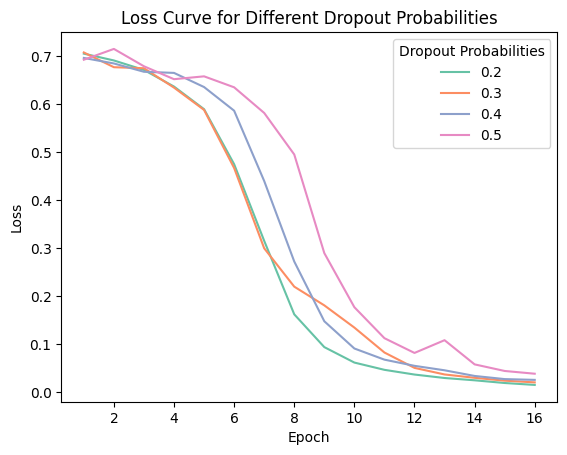

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updating the DataFrame without "Loss Series" in the series labels
data = {'Epoch': list(range(1, 17))}
for i, loss_list in enumerate(train_loss_list):
    data[["0.2", "0.3", "0.4", "0.5"][i]] = loss_list  # Using just the series label like '1e-3'

df = pd.DataFrame(data)
df_melted = df.melt('Epoch', var_name='dropout', value_name='Loss')

# Plotting with Seaborn
sns.lineplot(x='Epoch', y='Loss', hue='dropout', data=df_melted, palette="Set2")
plt.title('Loss Curve for Different Dropout Probabilities')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dropout Probabilities')
plt.show()

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels_train = train_df['high_30'].to_list()
actual_labels_val = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for lr in [1e-5]:
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True,
        seq_classif_dropout=0.2)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Number of training epochs
    num_epochs = 8

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_train, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_train)
        print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_val, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_val)
        print("Accuracy:", accuracy)
        print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.6964187114327042
Accuracy: 0.48142414860681115
Epoch 0: Average Validation Loss: 0.6693096888065339
Accuracy: 0.62
[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Epoch 1: Average Training Loss: 0.6681041366156236
Accuracy: 0.5913312693498453
Epoch 1: Average Validation Loss: 0.6147429382801056
Accuracy: 0.665
[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1

KeyboardInterrupt: ignored

<ipython-input-1-9af540dd28cf>:30: UserWarning: 
The dashes list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df, x='Epoch', y='Loss', hue='Type', style='Type', markers=True, dashes=[(1, 0), (4, 2)], palette=palette, style_order=style_order)


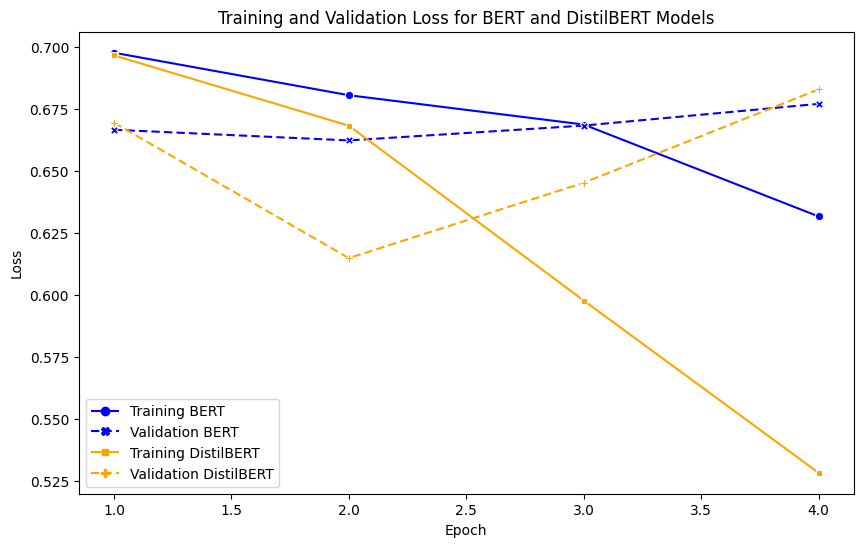

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data preparation
epochs = [1, 2, 3, 4]
data = {
    'Epoch': epochs * 4,
    'Loss': training_loss_bert + validation_loss_bert + training_loss_distil + validation_loss_distil,
    'Type': ['Training BERT'] * 4 + ['Validation BERT'] * 4 + ['Training DistilBERT'] * 4 + ['Validation DistilBERT'] * 4
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

#create a palette with a color for BERT and a color for DistilBERT
palette = {"Training BERT": "blue", "Validation BERT": "blue", "Training DistilBERT": "orange", "Validation DistilBERT": "orange"}

# solid and dashed lines
style_order = ["Training BERT", "Validation BERT", "Training DistilBERT", "Validation DistilBERT"]

sns.lineplot(data=df, x='Epoch', y='Loss', hue='Type', style='Type', markers=True, dashes=[(1, 0), (4, 2)], palette=palette, style_order=style_order)

#adjust the legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Training BERT', 'Validation BERT', 'Training DistilBERT', 'Validation DistilBERT']
new_handles = [handles[labels.index(l)] for l in new_labels]
plt.legend(new_handles, new_labels)

plt.title('Training and Validation Loss for BERT and DistilBERT Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()